# Basic Structure Similarity Analysis

This basic example will illustrate how to use Melodia to compare structural similarities between two proteins. Curvature and torsion are very sensitive to small changes in the backbone geometry and are also rotational invariant.

In [1]:
import dill
import warnings

import pandas as pd
import melodia as mel
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from math import sqrt
from sklearn.preprocessing import StandardScaler
from Bio.PDB.PDBExceptions import PDBConstructionWarning

warnings.filterwarnings("ignore", category=PDBConstructionWarning)

## Load data

For this example, we will load two proteins from the **Elicitin family**. They are small and exhibit very high similarity in their **chain A**.

In [2]:
df1 = mel.geometry_from_structure_file('1lri.pdb')
df1

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
0,0,0,1LRI,A,1,THR,0.523924,-0.118010,8.242813,-0.059194,0.000000,168.031125
1,1,0,1LRI,A,2,ALA,0.523924,-0.118010,7.896833,-0.059194,-75.363050,136.221155
2,2,0,1LRI,A,3,CYS,0.670033,-0.169718,7.896704,-0.059194,-60.494993,141.165783
3,3,0,1LRI,A,4,THR,0.569898,-0.180485,7.938670,-0.066212,-79.634848,173.203256
4,4,0,1LRI,A,5,ALA,0.697956,-0.010887,8.467120,0.010872,-63.077486,-37.574039
...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,0,1LRI,A,94,LYS,0.364685,0.162909,8.708571,0.226324,-59.899002,-45.781917
94,94,0,1LRI,A,95,CYS,0.327427,0.175978,8.718145,0.228522,-66.697245,-30.171642
95,95,0,1LRI,A,96,SER,0.436546,0.158725,8.642379,0.216261,-72.147382,-21.114371
96,96,0,1LRI,A,97,SER,0.496375,0.172698,8.514152,0.216261,-89.377454,0.000000


In [3]:
df2 = mel.geometry_from_structure_file('1ljp.pdb')
df2

,id,model,code,chain,order,name,curvature,torsion,arc_length,writhing,phi,psi
0,0,0,1LJP,A,1,THR,0.475242,-0.125397,8.238142,-0.062727,0.000000,123.434247
1,1,0,1LJP,A,2,ALA,0.475242,-0.125397,7.895721,-0.062727,-52.966483,142.570656
2,2,0,1LJP,A,3,CYS,0.577759,-0.180926,7.936894,-0.062727,-61.699471,142.615040
3,3,0,1LJP,A,4,THR,0.524319,-0.185755,7.971694,-0.068045,-77.004092,174.286670
4,4,0,1LJP,A,5,ALA,0.756870,-0.010564,8.509298,0.015778,-60.909800,-42.817054
...,...,...,...,...,...,...,...,...,...,...,...,...
191,93,0,1LJP,B,94,LYS,0.375810,0.160863,8.720161,0.230690,-57.620473,-46.106610
192,94,0,1LJP,B,95,CYS,0.320743,0.178252,8.722546,0.222234,-58.503926,-48.355355
193,95,0,1LJP,B,96,ALA,0.424603,0.156530,8.592585,0.221073,-59.100665,-27.127038
194,96,0,1LJP,B,97,SER,0.554346,0.157385,8.531393,0.221073,-86.496455,0.000000


***
The following figure shows the sequence alignment for the chains A in the loaded structures. The alignment is colour-coded using the **JOY annotation**.
***

![elicitin](elicitin.png)

<table>
    <tr>
        <td  style="width:40%"><img src="joy.png" alt="Drawing"/></td>
        <td>Mizuguchi, K., Deane, C.M., Blundell, T.L., Johnson,M.S. and Overington, J.P. (1998) JOY: protein sequence-structure representation and analysis. Bioinformatics 14:617-623</td>   
    </tr> 
</table>

## Select relevant data
In the following steps, we select only the chains A and join the DataFrames. We drop some columns as we will conduct just a curvature and torsion similarity analysis. .

In [4]:
df1a = df1.loc[df1['chain'] == 'A'].copy()
df1a.drop(['id', 'model', 'chain', 'arc_length', 'writhing','phi', 'psi'], axis=1, inplace=True)
df1a

,code,order,name,curvature,torsion
0,1LRI,1,THR,0.523924,-0.118010
1,1LRI,2,ALA,0.523924,-0.118010
2,1LRI,3,CYS,0.670033,-0.169718
3,1LRI,4,THR,0.569898,-0.180485
4,1LRI,5,ALA,0.697956,-0.010887
...,...,...,...,...,...
93,1LRI,94,LYS,0.364685,0.162909
94,1LRI,95,CYS,0.327427,0.175978
95,1LRI,96,SER,0.436546,0.158725
96,1LRI,97,SER,0.496375,0.172698


In [5]:
df2a = df2.loc[df2['chain'] == 'A'].copy()
df2a.drop(['id', 'model', 'chain', 'arc_length', 'writhing','phi', 'psi'], axis=1, inplace=True)
df2a

,code,order,name,curvature,torsion
0,1LJP,1,THR,0.475242,-0.125397
1,1LJP,2,ALA,0.475242,-0.125397
2,1LJP,3,CYS,0.577759,-0.180926
3,1LJP,4,THR,0.524319,-0.185755
4,1LJP,5,ALA,0.756870,-0.010564
...,...,...,...,...,...
93,1LJP,94,LYS,0.370525,0.165487
94,1LJP,95,CYS,0.328166,0.180256
95,1LJP,96,ALA,0.417953,0.155862
96,1LJP,97,SER,0.552572,0.162291


In [6]:
df = pd.concat([df1a, df2a], ignore_index=True)
df

,code,order,name,curvature,torsion
0,1LRI,1,THR,0.523924,-0.118010
1,1LRI,2,ALA,0.523924,-0.118010
2,1LRI,3,CYS,0.670033,-0.169718
3,1LRI,4,THR,0.569898,-0.180485
4,1LRI,5,ALA,0.697956,-0.010887
...,...,...,...,...,...
191,1LJP,94,LYS,0.370525,0.165487
192,1LJP,95,CYS,0.328166,0.180256
193,1LJP,96,ALA,0.417953,0.155862
194,1LJP,97,SER,0.552572,0.162291


## Data preprocessing

In [7]:
# Define the autoscaler from scikit-learn
autoscaler = StandardScaler()

# Define features for scaling
features = ['curvature', 'torsion']

# Scale the DataFrame
dfsd = df.copy()
dfsd[features] = autoscaler.fit_transform(dfsd[features])

dfsd

,code,order,name,curvature,torsion
0,1LRI,1,THR,0.774832,-0.592149
1,1LRI,2,ALA,0.774832,-0.592149
2,1LRI,3,CYS,1.676099,-0.796439
3,1LRI,4,THR,1.058422,-0.838978
4,1LRI,5,ALA,1.848337,-0.168918
...,...,...,...,...,...
191,1LJP,94,LYS,-0.171400,0.527916
192,1LJP,95,CYS,-0.432691,0.586263
193,1LJP,96,ALA,0.121157,0.489886
194,1LJP,97,SER,0.951548,0.515288


## Plot data for analysis
The following figures show the curvature and torsion data for the selected chains. Despite the highly conserved sequences, the structures show distinct geometric behaviour in diverse points. 
**The curvature and torsion values are sensitive enough to contrast tiny but fundamental changes in the protein's geometry that other measures, like RMSD, cannot do.**


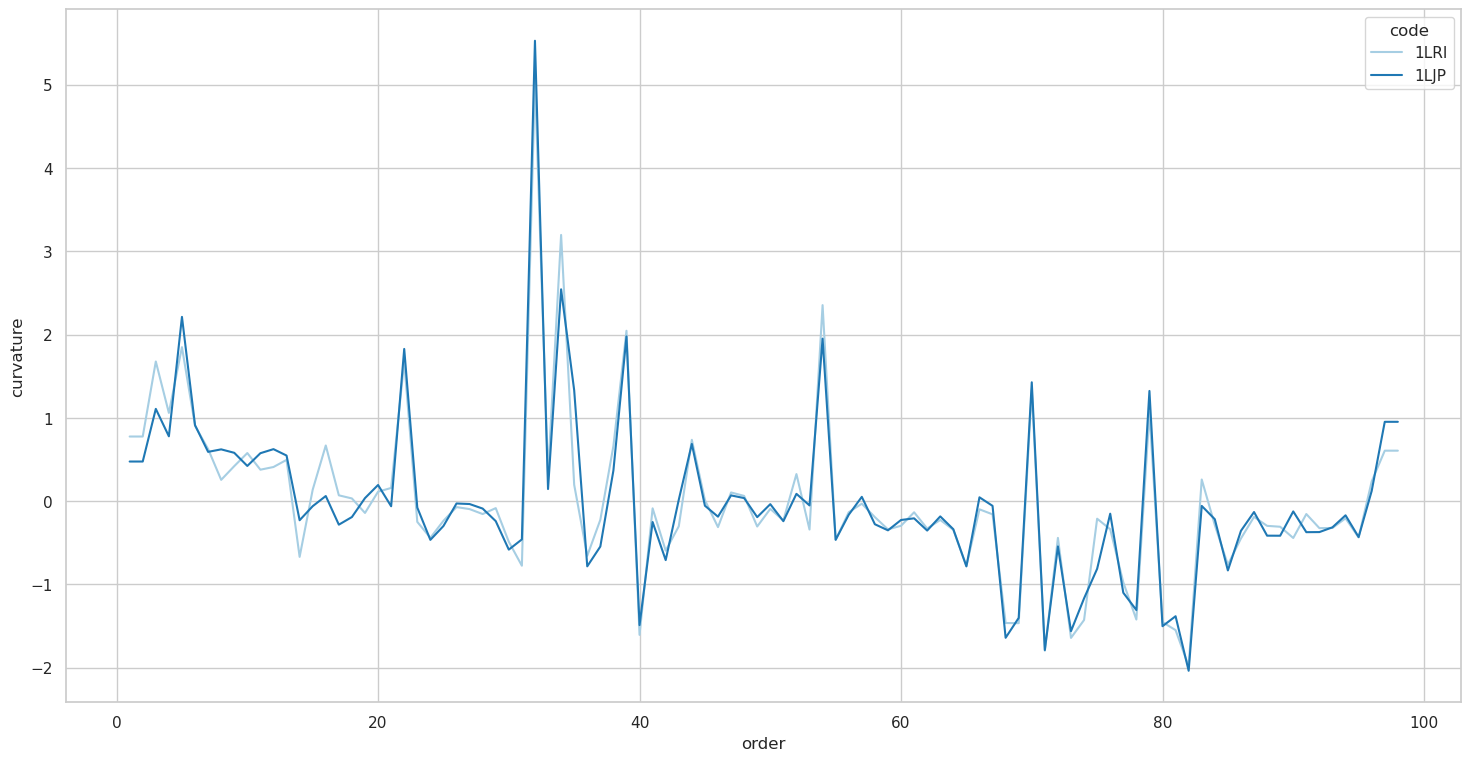

In [8]:
sns.set(rc={'figure.figsize':(18.0, 9.0)})
sns.set_theme(style='whitegrid', palette='Paired')
sns.lineplot(x="order", y="curvature", hue="code", data=dfsd);

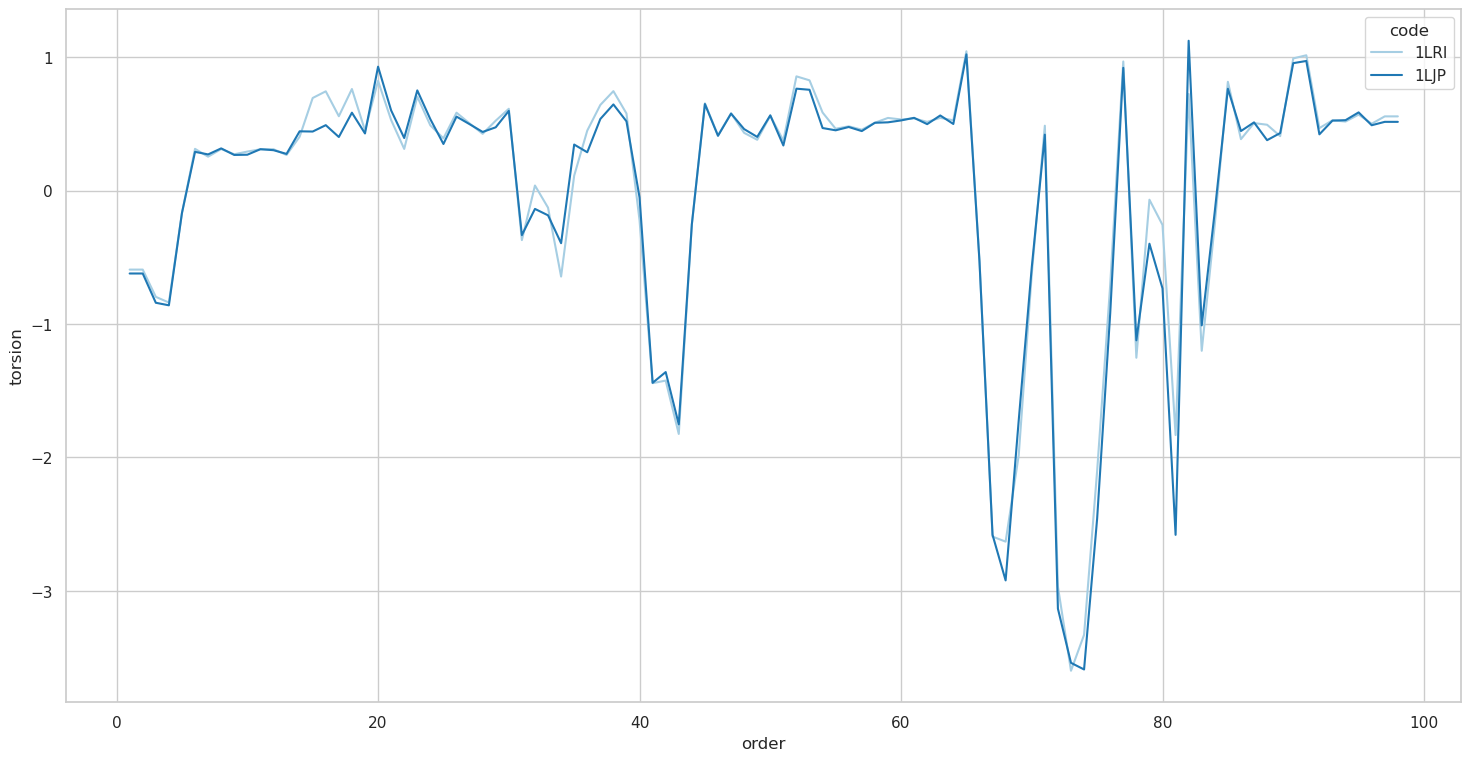

In [9]:
sns.set(rc={'figure.figsize':(18.0, 9.0)})
sns.set_theme(style='whitegrid', palette='Paired')
sns.lineplot(x='order', y='torsion', hue='code', data=dfsd);

## Curvature and Torsion metric
We can also use Pandas' functions to quickly create a DataFrame with the Euclidian distance between **curvature and torsion**. We can employ the Euclidian distance as a measure of local geometric dissimilarity. 



In [10]:
# Merge the two chains using the proteins code as suffixes
dft = pd.merge(df1a, df2a, how='left', suffixes=['_1LRI', '_1LJP'], on='order')
dft.drop(['code_1LRI', 'code_1LJP'], axis=1, inplace=True)
dft

,order,name_1LRI,curvature_1LRI,torsion_1LRI,name_1LJP,curvature_1LJP,torsion_1LJP
0,1,THR,0.523924,-0.118010,THR,0.475242,-0.125397
1,2,ALA,0.523924,-0.118010,ALA,0.475242,-0.125397
2,3,CYS,0.670033,-0.169718,CYS,0.577759,-0.180926
3,4,THR,0.569898,-0.180485,THR,0.524319,-0.185755
4,5,ALA,0.697956,-0.010887,ALA,0.756870,-0.010564
...,...,...,...,...,...,...,...
93,94,LYS,0.364685,0.162909,LYS,0.370525,0.165487
94,95,CYS,0.327427,0.175978,CYS,0.328166,0.180256
95,96,SER,0.436546,0.158725,ALA,0.417953,0.155862
96,97,SER,0.496375,0.172698,SER,0.552572,0.162291


In [11]:
# Define features for scaling
features = ['curvature_1LRI', 'torsion_1LRI', 'curvature_1LJP', 'torsion_1LJP']

# Scale the DataFrame
dftsd = dft.copy()
dftsd[features] = autoscaler.fit_transform(dftsd[features])
dftsd

,order,name_1LRI,curvature_1LRI,torsion_1LRI,name_1LJP,curvature_1LJP,torsion_1LJP
0,1,THR,0.776046,-0.617255,THR,0.474188,-0.596841
1,2,ALA,0.776046,-0.617255,ALA,0.474188,-0.596841
2,3,CYS,1.679884,-0.824854,CYS,1.104771,-0.812889
3,4,THR,1.060445,-0.868082,THR,0.776060,-0.831676
4,5,ALA,1.852614,-0.187168,ALA,2.206483,-0.150054
...,...,...,...,...,...,...,...
93,94,LYS,-0.209012,0.510600,LYS,-0.169925,0.534913
94,95,CYS,-0.439492,0.563073,CYS,-0.430478,0.592371
95,96,SER,0.235520,0.493804,ALA,0.121804,0.497462
96,97,SER,0.605625,0.549903,SER,0.949848,0.522476


In [12]:
# Define the Euclidian distance between the two proteins
def dist(row):
    d = (row['curvature_1LRI'] - row['curvature_1LJP'])**2 + (row['torsion_1LRI'] - row['torsion_1LJP'])**2
    return sqrt(d)

# Create new columns with the Euclidian distance
dftsd['dist'] = dftsd.apply(dist, axis=1)
dftsd

,order,name_1LRI,curvature_1LRI,torsion_1LRI,name_1LJP,curvature_1LJP,torsion_1LJP,dist
0,1,THR,0.776046,-0.617255,THR,0.474188,-0.596841,0.302547
1,2,ALA,0.776046,-0.617255,ALA,0.474188,-0.596841,0.302547
2,3,CYS,1.679884,-0.824854,CYS,1.104771,-0.812889,0.575238
3,4,THR,1.060445,-0.868082,THR,0.776060,-0.831676,0.286706
4,5,ALA,1.852614,-0.187168,ALA,2.206483,-0.150054,0.355810
...,...,...,...,...,...,...,...,...
93,94,LYS,-0.209012,0.510600,LYS,-0.169925,0.534913,0.046032
94,95,CYS,-0.439492,0.563073,CYS,-0.430478,0.592371,0.030654
95,96,SER,0.235520,0.493804,ALA,0.121804,0.497462,0.113775
96,97,SER,0.605625,0.549903,SER,0.949848,0.522476,0.345314


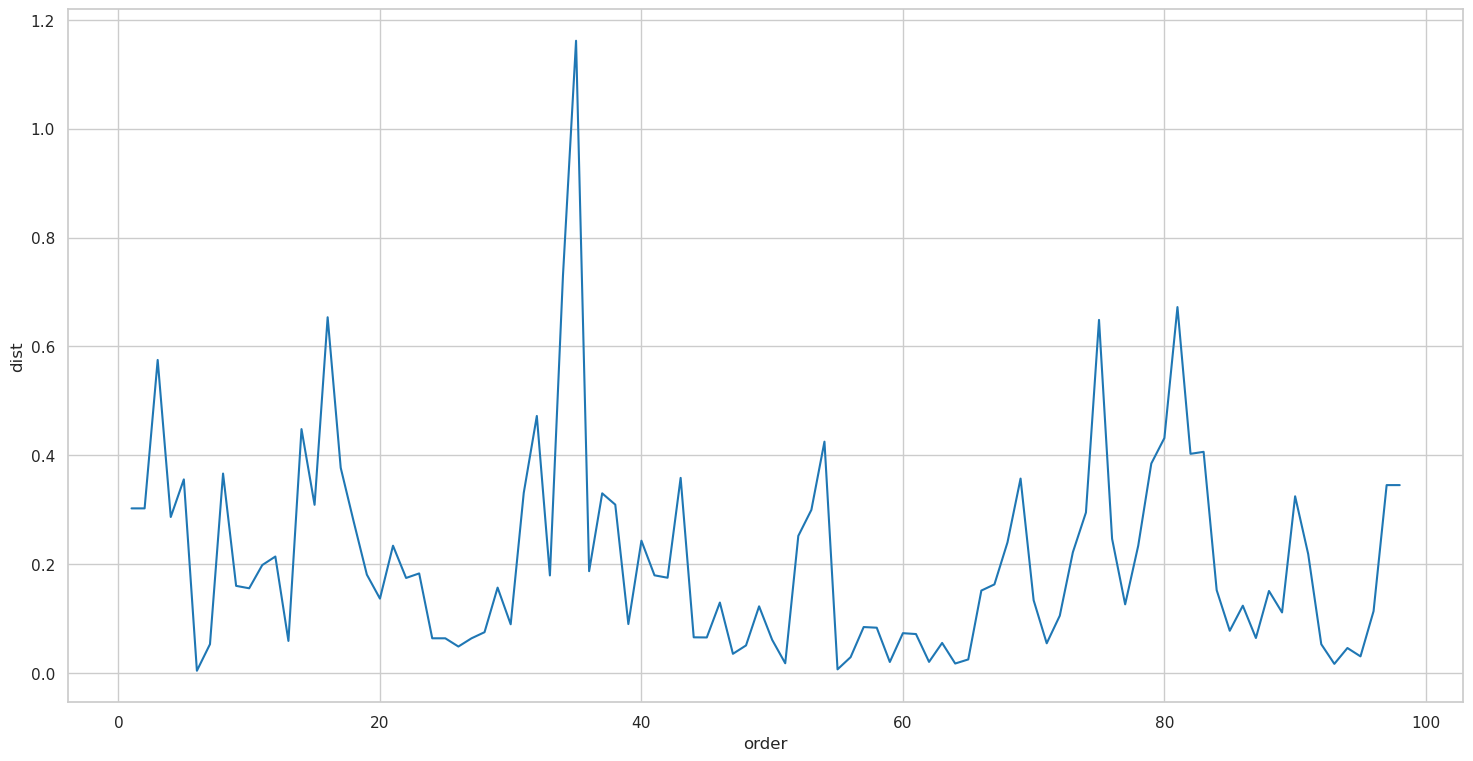

In [13]:
# Plot the Euclidian distance
sns.set(rc={'figure.figsize':(18.0, 9.0)})
sns.set_theme(style='whitegrid', palette='tab10')
sns.lineplot(x='order', y='dist', data=dftsd);

## Helix analysis

Let us select only the first 25 residues covering the helix.

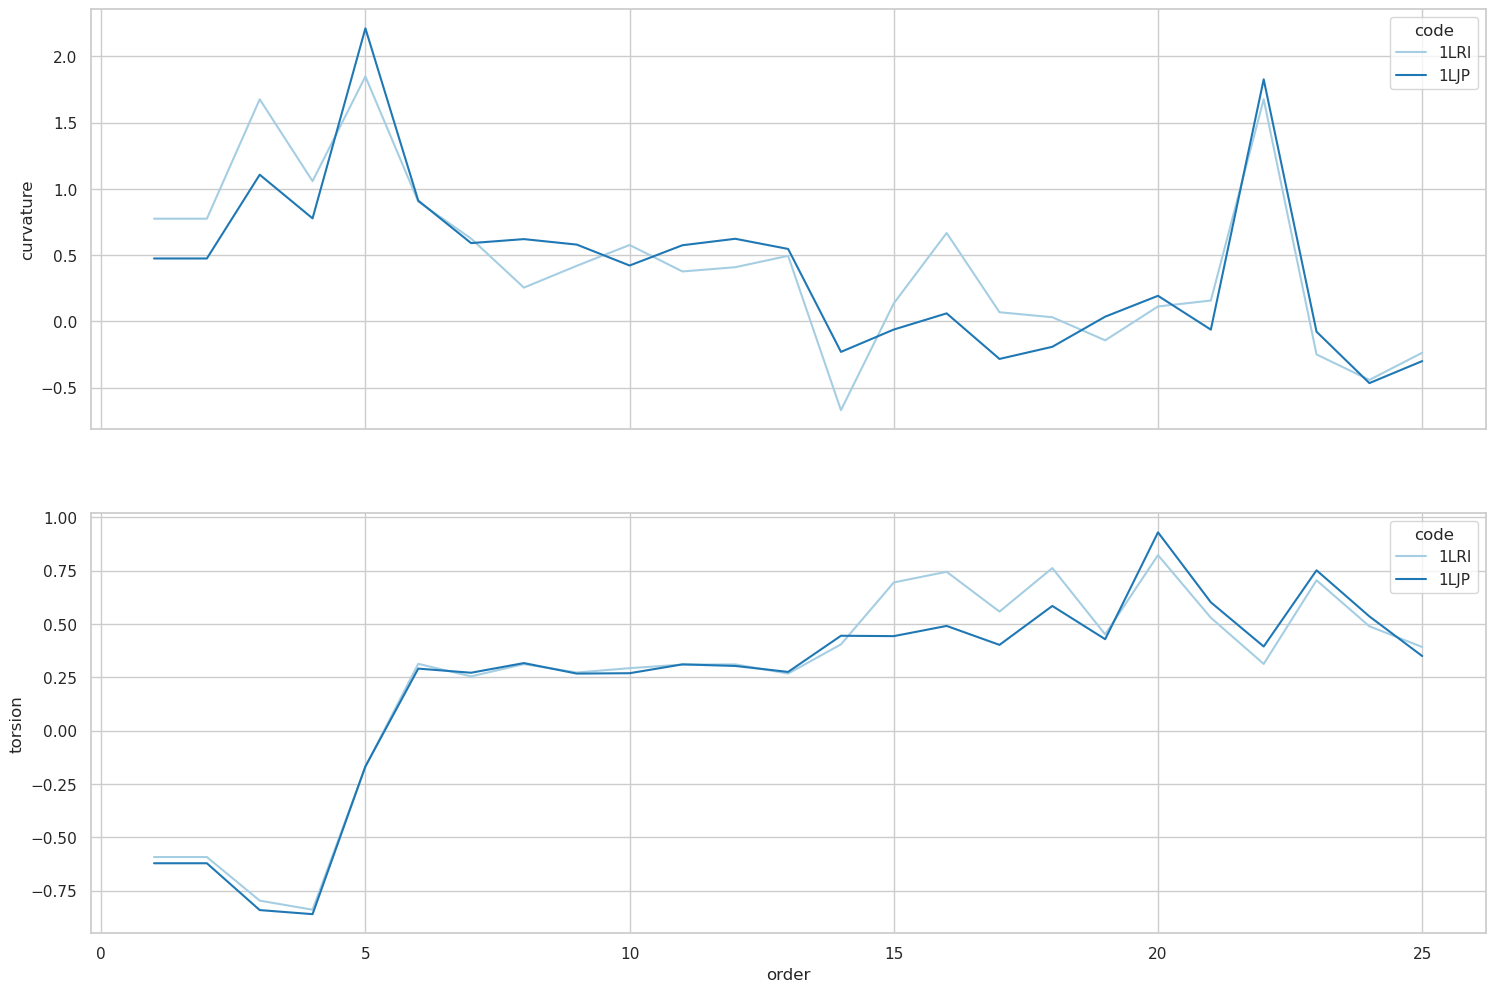

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18.0, 12.0))
sns.set_theme(style='whitegrid', palette='Paired')
sns.lineplot(x="order", y="curvature", hue="code", data=dfsd[dfsd['order'] <= 25], ax=axes[0])
sns.lineplot(x="order", y="torsion", hue="code", data=dfsd[dfsd['order'] <= 25], ax=axes[1]);

<table>
    <tr>
        <td style="width:50%"><img src="elicitin_stru.png" alt="Drawing"/></td>
        <td><img src="elicitin_helix.png" alt="Drawing"/></td>   
    </tr> 
    <tr>
        <td>1LRI in ligth blue and 1LJ in blue.</td>
        <td>Residues from number 6 to number 25 coloured by torsion.</td>
</table>

***
Observing the plots, we see a significant change in the curvature and torsion values after residue 14. It is due to the geometric changes from an **alpha-helix to a 3-10-helix**, as we can verify in the annotated alignment.
***

# RMSD-based analysis

Despite similarities between RMSD and the differential geometry distance, they differ due to the former dependency on protein superposition (and, thus, the choices for that) and lack of geometric descriptive power. This section will analyse the difference between the two proteins using RMSD and compare the results to those of the differential geometry. Initially, we superimposed two proteins using PyMol and computed the backbone RMSD to create a CSV file (__[PyMol RMSDCa script](https://github.com/tongalumina/rmsdca)__).

Let us select load the RMSD per residue.

In [15]:
dfrmsd = pd.read_csv('rmsd_res.csv')
dfrmsd

,refMol,refRes,refResID,target,residueName,residueId,rmsdResCa,rmsdResBackbone
0,1ljp,THR,1,1lri,THR,1,2.253,2.186
1,1ljp,ALA,2,1lri,ALA,2,1.731,1.547
2,1ljp,CYS,3,1lri,CYS,3,0.796,1.069
3,1ljp,THR,4,1lri,THR,4,1.249,1.191
4,1ljp,ALA,5,1lri,ALA,5,1.992,1.884
...,...,...,...,...,...,...,...,...
93,1ljp,LYS,94,1lri,LYS,94,0.248,0.251
94,1ljp,CYS,95,1lri,CYS,95,0.262,0.436
95,1ljp,ALA,96,1lri,SER,96,0.391,0.403
96,1ljp,SER,97,1lri,SER,97,0.371,0.333


<img src="rmsd_res.png" width="800">

***
This figure shows the RMSD per residue as the **b-factor** on the reference molecule.
***

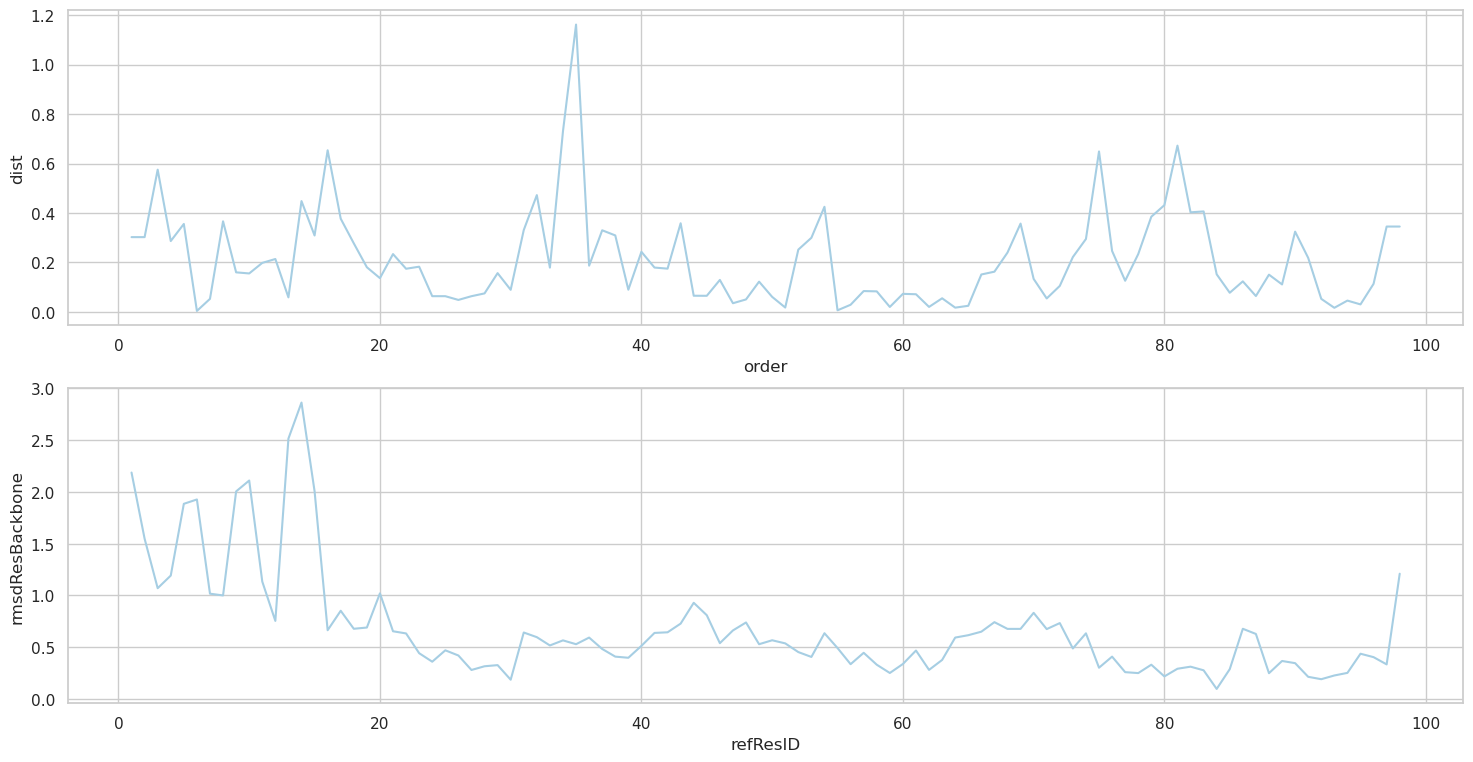

In [16]:
# Plot the RMSD
fig, ax =plt.subplots(2,1)
sns.set(rc={'figure.figsize':(18.0, 9.0)})
sns.set_theme(style='whitegrid', palette='tab10')
sns.lineplot(x='order', y='dist', data=dftsd, ax=ax[0])
sns.lineplot(x='refResID', y='rmsdResBackbone', data=dfrmsd, ax=ax[1]);

***
By comparing the backbone RMSD with the differential geometry distance, we can see that although the RMSD can detect significant differences in the initial region of proteins (1st helix), it fails to detect essential but subtle geometry changes like the one around residue 35. 
***

In [17]:
dftsd[(dftsd['order'] >= 20) & (dftsd['order'] <= 40)]

,order,name_1LRI,curvature_1LRI,torsion_1LRI,name_1LJP,curvature_1LJP,torsion_1LJP,dist
19,20,SER,0.111637,0.819952,SER,0.193192,0.929761,0.136782
20,21,ASP,0.156456,0.521886,GLU,-0.061518,0.606930,0.233977
21,22,ALA,1.680189,0.301964,SER,1.822642,0.403149,0.174732
22,23,SER,-0.251782,0.700185,SER,-0.077019,0.754639,0.183050
23,24,PHE,-0.444251,0.481272,PHE,-0.463964,0.542042,0.063887
24,25,ASN,-0.238845,0.382531,SER,-0.298236,0.359072,0.063857
25,26,GLN,-0.073994,0.578024,GLN,-0.028238,0.561262,0.048730
26,27,CYS,-0.098032,0.496287,CYS,-0.034876,0.505313,0.063798
27,28,SER,-0.157711,0.417090,SER,-0.089247,0.447939,0.075093
28,29,THR,-0.086433,0.517185,LYS,-0.239491,0.482299,0.156983


## Let us have a closer look at the helical region

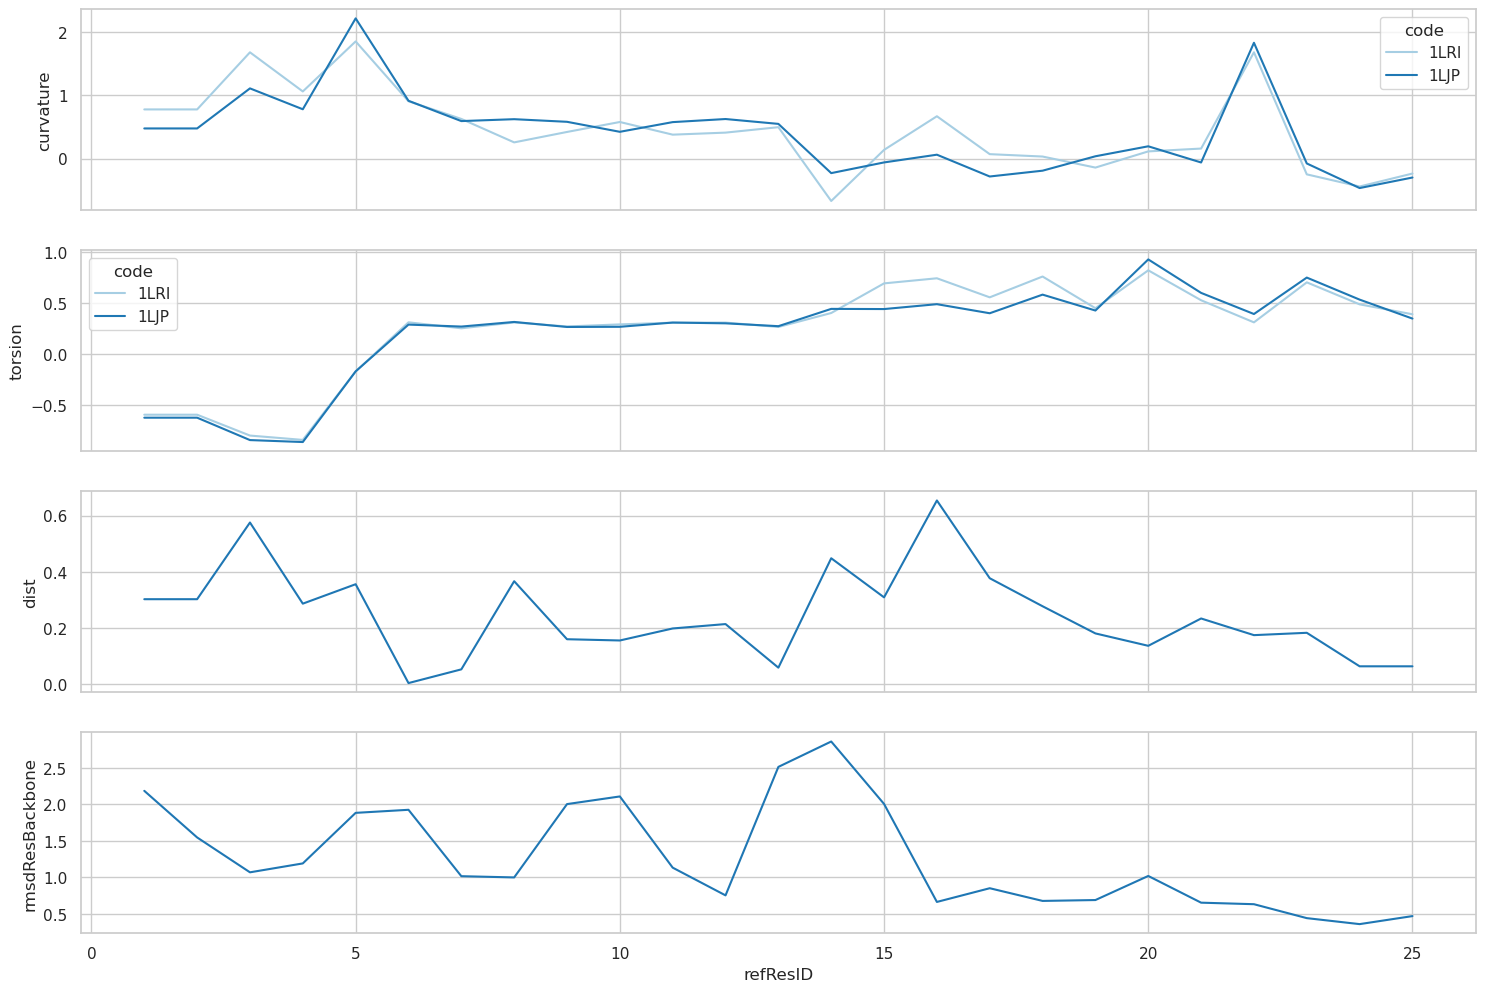

In [18]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(18.0, 12.0))
sns.set_theme(style='whitegrid', palette='Paired')
sns.lineplot(x="order", y="curvature", hue="code", data=dfsd[dfsd['order'] <= 25], ax=axes[0])
sns.lineplot(x="order", y="torsion", hue="code", data=dfsd[dfsd['order'] <= 25], ax=axes[1])
sns.lineplot(x='order', y='dist', data=dftsd[dftsd['order'] <= 25], ax=axes[2])
sns.lineplot(x='refResID', y='rmsdResBackbone', data= dfrmsd[dfrmsd['refResID'] <= 25], ax=axes[3]);

<img src="rmsd_res_1_25.png" width="800">

By closely looking at the first helical region, we can observe that RMSD measures can perceive the local changes in the geometry similarly to the differential geometry distance. The differential geometry distance is just one measure of dissimilarity between the residues. However, **curvature** and **torsion** has more information about the local geometry than the RMSD. The higher Torsion for the protein 1LRI at residue number 13 indicates that its alpha-helix is starting to turn into a \$3_{10}$ helix.The differential geometry values are more sensitive and contain more information than the RMSD. It can automatically classify and describe the local geometry of protein backbones. For a deeper dive into this field, please refer to:

<ol>
    <li>Røgen P, Fain B: Automatic classification of protein structure by using Gaussa Integrals. 2003, 100:119-124.</li>
    <li>Guo Z, Cremer D: Methods for a Rapid and Automated Description of Proteins. Reviews in Computational Chemistry. 2016, 29:369-438.</li>
</ol>

Reference 1 explains the limitations of RMSD in describing the geometry of protein backbones, and reference 2 completes the treatment of curvature and torsion as a superior descriptor of the geometry of the local structure of proteins.